# PHYS555 - Machine Learning Project - Q3

Karlee Zammit - V00823093

## Use 'sklearn.svm.SVR'  for regression. Compare results (using regression metrics such as scatter, mean, median and associated plots/histograms) with the best results from an ANN model and discuss the comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter  
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Regression stats plots
def stats_plots(Y_tr, Y_va, Y_tr_pred, Y_va_pred, xlim, ylim, textx, texty, text2x, text2y, title, x_var):
    
    plt.figure(1)
    plt.plot(Y_tr,Y_tr_pred,'ob')
    plt.plot(Y_va,Y_va_pred,'.r')

    plt.plot(np.arange(xlim,ylim,.1),  np.arange(xlim,ylim,.1),'-k')
    plt.xlabel(str(x_var))
    plt.ylabel('Predicted ' + str(x_var))
    plt.legend(['Training', 'Validation'], loc='best')

    plt.text(textx,texty,textstr, color='b',fontsize=15)
    plt.text(text2x,text2y,textstrv, color='r',fontsize=15)
    plt.title(str(title))

    plt.figure(2)
    plt.hist(Y_tr_pred-Y_tr,20,color='b',histtype='step',density=True,label='training')
    plt.hist(Y_va_pred-Y_va,20,color='r',histtype='step',density=True,label='validation')
    plt.xlabel('Predicted - real')
    plt.ylabel('Probability (density)')
    plt.legend(loc='upper left')

    plt.figure(3)
    plt.scatter(Y_tr,Y_tr_pred-Y_tr,label='training',color='b',alpha=.3)
    plt.scatter(Y_va,Y_va_pred-Y_va,label='test',color='r',alpha=.3)
    plt.xlabel('Y (real)')
    plt.ylabel('Y (predicted) - Y (real)')
    plt.plot([xlim,ylim],[0,0],'y')
    plt.legend(loc='best')


In [3]:
df_SH = pd.read_excel('Ambient Sound Data Sachs Harbour 2015-2016.xlsx')
print('The shape of the dataframe is ' + str(df_SH.shape))

# Count the existing nans
nan_count = df_SH.isna().sum().sum()
print(nan_count)
df_SH=df_SH.dropna(axis=0)
print('The shape of the dataframe after dropping NaNs is ' + str(df_SH.shape))

df_SH.head()

The shape of the dataframe is (9982, 23)
564
The shape of the dataframe after dropping NaNs is (9642, 23)


,Deployment,Year,Month,Day,Hour,DateTime,10-100Hz,100-1000Hz,1-10kHz,10-24kHz,...,DewPt,RelHum,WindDir,WindSp,Pressure,Ice6km2,Ice19km2,Ice31km2,Ice106km2,Ice
0,1,2015,5,18,15,2015-05-18 15:00:00,86.113543,83.540120,75.726148,65.178992,...,-0.1,70.0,15.0,9.0,101.52,13.5,32.222222,39.478261,31.961039,0.0
1,1,2015,5,18,16,2015-05-18 16:00:00,86.100652,96.371012,89.047766,70.179126,...,0.1,71.0,16.0,12.0,101.53,13.5,32.222222,39.478261,31.961039,0.0
2,1,2015,5,18,17,2015-05-18 17:00:00,69.981675,98.985918,91.915703,65.467056,...,0.6,72.0,15.0,12.0,101.51,13.5,32.222222,39.478261,31.961039,0.0
3,1,2015,5,18,18,2015-05-18 18:00:00,68.305432,97.577544,91.349444,65.249551,...,1.4,73.0,13.0,16.0,101.47,13.5,32.222222,39.478261,31.961039,0.0
4,1,2015,5,18,19,2015-05-18 19:00:00,68.952387,98.386537,91.631783,65.269117,...,1.1,76.0,13.0,24.0,101.44,13.5,32.222222,39.478261,31.961039,0.0


In [4]:
# Drop non necessary columns 
df_SH = df_SH.drop(['Deployment','DateTime', 'Ice'], axis=1)

# Create dataframe for histogram plotting
df_hist = df_SH.drop(['Month', 'Day', 'Year', 'Hour'], axis=1)

In [5]:
# Set Ice Concentration as the target variable
var = ['Ice106km2']

# Drop temperature out of the weather data, and set it as X
X = df_SH.loc[:,df_SH.columns.drop(var)]
print(X.columns)

# Set the target (Y) to be temperature
Y = df_SH[var].copy()
print(Y.columns)

# Call the split data function
X_tr, X_va, Y_tr, Y_va = train_test_split(X,Y.values.ravel(),test_size=0.25)

# Print the shape of the split data
print ('training set == ',np.shape(X_tr),np.shape(Y_tr),',, validation set == ', np.shape(X_va),np.shape(Y_va))

# Normalize the data, as was done in Q2
scaler_S= StandardScaler().fit(X_tr)  # line #2
X_tr_Norm= scaler_S.transform(X_tr) # line # 3
X_va_Norm= scaler_S.transform(X_va)  # Line #4

Index(['Year', 'Month', 'Day', 'Hour', '10-100Hz', '100-1000Hz', '1-10kHz',
       '10-24kHz', '250Hz', '50-1000Hz', 'Temperature', 'DewPt', 'RelHum',
       'WindDir', 'WindSp', 'Pressure', 'Ice6km2', 'Ice19km2', 'Ice31km2'],
      dtype='object')
Index(['Ice106km2'], dtype='object')
training set ==  (7231, 19) (7231,) ,, validation set ==  (2411, 19) (2411,)


# ANN

In [6]:
#ann_pipeline = Pipeline([('ANNreg', MLPRegressor(hidden_layer_sizes=(20,20), n_iter_no_change=5, validation_fraction=0.1, early_stopping=True, max_iter=500))])
            
#params = [{'ANNreg__activation':['relu', 'tanh'], 'ANNreg__solver':['sgd', 'adam'], 'ANNreg__learning_rate':['constant', 'invscaling', 'adaptive']}]

#gs_ann = GridSearchCV(ann_pipeline,
#                      param_grid=params,
#                      scoring='neg_mean_squared_error',
#                      cv=5)

#gs_ann.fit(X_tr_Norm, Y_tr)
#.argmax(axis=1)

#gs_ann.best_params_

Results from the above (commented out for sake of time when rerunning) for neg_mean_squared_error: 
- Activation: tanh
- Learning rate: adaptive
- Solver: sgd

In [7]:
# THIS NEEDS TO BE UPDATED - THE THING ABOVE DIDN'T FINISH
reg_ann = MLPRegressor(hidden_layer_sizes=(20,20), n_iter_no_change=5, validation_fraction=0.1, early_stopping=True, max_iter=500, activation='tanh', solver='sgd', learning_rate='adaptive')

reg_ann.fit(X_tr_Norm, Y_tr)

Y_tr_pred_ann = reg_ann.predict(X_tr_Norm)  
Y_va_pred_ann = reg_ann.predict(X_va_Norm)

NameError: name 'textstr' is not defined

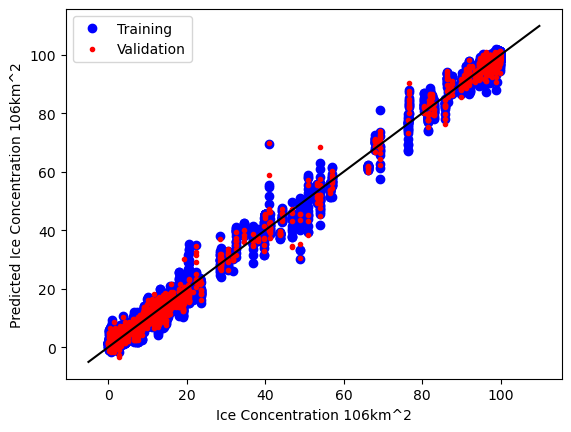

In [8]:
stats_plots(Y_tr, Y_va, Y_tr_pred_ann, Y_va_pred_ann, -5, 110, 125, 10, 125, 40, title='ANN for Sachs Harbour', x_var = 'Ice Concentration 106km^2')

# SVM

In [ ]:
#sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
regr = make_pipeline(SVR(C=1.0, epsilon=0.2))
regr.fit(X_tr_Norm, Y_tr)

In [ ]:
Y_tr_pred = regr.predict(X_tr_Norm)  
Y_va_pred = regr.predict(X_va_Norm)

In [ ]:
stats_plots(Y_tr, Y_va, Y_tr_pred, Y_va_pred, -5, 110, 125, 10, 125, 40, title='SVM for Sachs Harbour', x_var = 'Ice Concentration 106km^2')

# References 

**Sachs Harbour Dataset:** 

Insley, S. J., Halliday, W. D., & de Jong, T. (2017). Seasonal Patterns in Ocean Ambient Noise near Sachs Harbour, Northwest Territories. Arctic, 70(3), 239–248. https://doi.org/10.14430/arctic4662

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

